# Holistic Determination of Optoelectronic Properties using High-Throughput Spectroscopy of Surface-Guided CsPbBr3 Nanowires

Authors:
- _Stephen Church (stephen.church@manchester.ac.uk)_
- _Hoyeon Choi (hoyeon.choi@postgrad.manchester.ac.uk)_
- _Nawal Al-Amairi (nawal.alamairi@postgrad.manchester.ac.uk)_
- _Ruqaiya Al-Abri (ruqaiya.al-abri@postgrad.manchester.ac.uk)_
- _Ella Sanders (ella.sanders@weizmann.ac.il)_
- _Eitan Oksenberg (e.oksenberg@amolf.nl)_
- _Ernesto Joselevich (ernesto.joselevich@weizmann.ac.il)_
- _Patrick Parkinson (patrick.parkinson@manchester.ac.uk)_


Reference:
This workbook demonstrates the analysis used in the associated publication (ACS Nano ###, ###).

---

The workbook consists of a number of sections - the downloading of datasets, the preparation of the Keras model for carrier diffusion, and the modelling of the data.

We have a number of flags for the operation of this code:

In [224]:
CLEAN = True

## Download datasets and models

The raw data is stored on dropbox, and consists of matlab files with saved keras model states.

In [225]:
import os                           # Required for file management
import zipfile                      # Required for file management
import glob                         # Required for file management
import urllib.request as url        # Require for file management

import numpy as np                  # Required for math
import tables                       # Used to load files
import time                         # Monitor the runtime

import tensorflow as tf             # Used for ML modelling of 2D carrier diffusion
from tensorflow import keras        # Used for ML modelling of 2D carrier diffusion

import matplotlib.pyplot as plt     # For general plotting

from scipy.optimize import minimize # Basic least squares optimization
#import scipy.io as spio             # Basic in/out

First, we remove any existing downloads

In [226]:
if CLEAN:
    fileList = glob.glob('*.mat') + glob.glob('*.zip') +  glob.glob('./*.h5') +  glob.glob('./mymodel/*.pb') + glob.glob('./mymodel/variables/*')
    for f in fileList:
        os.remove(f)
        try:
            os.removedirs("./mymodel/variables")
        except:
            pass

The data is split into two - raw data and model data:

In [479]:
# http location of datafiles
location = {'mymodel':'https://www.dropbox.com/s/en5cv6rou73qvml/mymodel.zip?dl=1',
           'nanowire_data.h5':'https://www.dropbox.com/s/2hcsuz76x3n4bkp/nanowire_data.h5.zip?dl=1'}

We use a helper function to download and upzip the datafiles.

In [480]:

def load_and_unzip(filename:str) -> None:
  """Retrieve, unzip and prepare datafiles required for the simulation."""
  zipfile_present = os.path.isfile(f'{filename}.zip')
  data_folder_present = os.path.isdir(filename)

  if not(zipfile_present or data_folder_present):
    print(f'Downloading datafile {filename} from dropbox')
    url.urlretrieve(location[filename],filename=f'{filename}.zip')

  if not(data_folder_present):
    print("Extracting data from zip-file")
    with zipfile.ZipFile(f'{filename}.zip', 'r') as zip_ref:
        zip_ref.extractall()
    print('Done extracting data')
    
  fileList = glob.glob('*.zip')
  for f in fileList:
    os.remove(f)

Retrieve the data and model

In [481]:
load_and_unzip('mymodel')
load_and_unzip('nanowire_data.h5')

Extracting data from zip-file
Done extracting data


In [482]:
data_root = tables.open_file("nanowire_data.h5", mode="r")
dataset = data_root.root.nanowires

### Create variables from the input data

We have four datasets:
- top: excitation from top interface, 
- bottom: excitation from lower interface
- power_dependant: power-dependant data for threshold and 
- top-bottom: wires with correlated excitation from the top and bottom

The raw input data needs to be converted into physically meaningful units. In particular:

- Bandgap is calculable from photoluminscence bandgap

In [242]:
#files = ['C3_top','C3_bottom','pdep_tcspc','C3_top_bottom']
# 0 - top, 1 - bottom, 2 - pdep, 3 - top_bottom, 4 - pdep, 5 - top_bottom

# Shortcuts to fitting data.
spectral_fit_top    = dataset.spectral_top.urbach_fitting
spectral_fit_bottom = dataset.spectral_bottom.urbach_fitting

In [483]:
#PL energy analysis
#convert from PL peak energy to bandgaps using a cubic interpolation

# Mask where data exists from both top and bottom
top_and_bottom_mask = np.where((np.isnan(spectral_fit_top.peak)==False)[0] &
                (np.isnan(spectral_fit_bottom.peak)==False)[0])[0]

# Cubic interpolation code
def fit_Eg(data):
    q = np.polyfit(np.squeeze(data.peak[:,top_and_bottom_mask]),np.squeeze(data.E_0[:,top_and_bottom_mask]),3)
    Eg = np.polyval(q,data.peak[:,top_and_bottom_mask])
    return np.squeeze(Eg)

# Interpolate for top and bottom
Eg_top = (fit_Eg(spectral_fit_top),top_and_bottom_mask)
Eg_bottom = (fit_Eg(spectral_fit_bottom),top_and_bottom_mask)
# Get the difference
E_shifts = (Eg_top[0] - Eg_bottom[0],top_and_bottom_mask)

def gen_mask(d):
    d = np.squeeze(d)
    m = np.bitwise_not(np.isnan(d))
    return (d[m],m)

#Iratio is the ratio of the integral of the TCSPC fitting for top excitation
Iratios = gen_mask(dataset.tcspc_top.Fitting.int_ratio)

#extract lifetime data
#parameter labelling: surface, SA, s, 1
#                     bulk, v, 2
t_top_bulk_data = gen_mask(dataset.tcspc_top.Fitting.tau2)
t_top_SA_data = gen_mask(dataset.tcspc_top.Fitting.tau1)
t_bot_data = gen_mask(dataset.tcspc_bottom.Fitting.tau1)


#Extract power dependent TCSPC results, exciting from the top
#threshold and slope above threshold for each lifetime
thresh_SA = gen_mask(dataset.power_dependent_tcspc.thresh_ts)
thresh_bulk = gen_mask(dataset.power_dependent_tcspc.thresh_tv)
slope_SA = gen_mask(dataset.power_dependent_tcspc.slope_ts)
slope_bulk = gen_mask(dataset.power_dependent_tcspc.slope_tv)


(array([ 758.,  973., 1185., 1295., 1273.,  939.,  676.,  521.,  364.,
         358.]),
 array([1.06119045, 1.0929742 , 1.12475795, 1.15654171, 1.18832546,
        1.22010921, 1.25189297, 1.28367672, 1.31546047, 1.34724423,
        1.37902798]),
 <BarContainer object of 10 artists>)

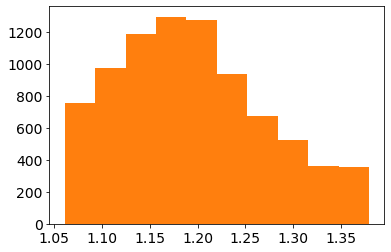

In [459]:
#widths ahead of time to save time
#NW width scaling factors - obtained from SEM
width_sf = (0.76069853, 0.17673849);

#widths to display
display_width = width_sf[0]+width_sf[1]*np.linspace(1.7,3.5,46) #um  

#widths for all wires
data_width = np.squeeze(np.array(dataset.geometry.width))
data_width_bottom = np.squeeze(width_sf[0]+width_sf[1]*np.array(dataset.geometry.width_bottom))
data_width_bottom = np.squeeze(np.array(dataset.geometry.width_bottom))

plt.hist(np.squeeze(np.array(dataset.geometry.width_bottom)))

##########Use top width if present, otherwise use bottom width
data_width = np.nan_to_num(data_width) + np.multiply(np.isnan(data_width),np.nan_to_num(data_width_bottom))
data_width[data_width==0]=np.nan;

---
## Machine Learning model for carrier diffusion

A simple neural network model is used to convert physical parameters (such as the width of the nanowire, the diffusion length, and the surface thickness) to the fraction of photocarriers that diffuse to the surface, interface or bulk of each nanowire. An ML model is used, trained on a two-dimensional Monte-Carlo model, to accelerate the use the physical model in the fitting process.

### Load ML model

The model is saved as "mymodel" as a keras network with three dense layers and a softmax output.

In [245]:
model = keras.models.load_model('mymodel')
model.summary()

Model: "myModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 5)]               0         
                                                                 
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 32)                192       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                           

### Test machine learning model

The ML model converts five inputs (two as one-hot for the excitation direction, either bottom or top, and three continuous variables describing nanowire width, diffusion length and surface thickness). The three continuous variables are in micron units.

The output is as a three element vector showing the fraction of photocarriers that diffuse to the bottom or top surface, or to the volume of the wire (as determined by the "surface thickness" input variable).

We start by exploring these fraction as a function of nanowire width.

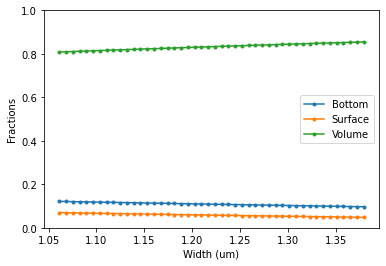

In [246]:
# Generate a set of inputs to the model
input = np.array([[1,0,w,0.4,0.01] for w in display_width])

# Run prediction
pred = model.predict(input)

# Plot results
def plot_fractions(x:np.ndarray, frac:np.ndarray,variable:str='Arb') -> None:
  plt.plot(x,frac,'.-')
  plt.xlabel(variable)
  plt.ylabel('Fractions')
  plt.legend(['Bottom','Surface','Volume'])
  plt.ylim([0, 1])

plot_fractions(display_width,pred,variable='Width (um)')

## Dynamical model

The complete model for understanding absolute intensity, carrier dynamics and strain in the CsPbBr nanowires is described in the main manuscript. In essence, it is made of a a number of linked functions which describe specific processes.

### Fit vector

Throughout this model, the variable $p$ is the 13-element fit vector comprising:
- **Ldiff** : diffusion length of carriers
- **krV** : radiative recombination rate in the bulk
- **ktV** : non-radiative rate in the bulk
- **ktSA** : non-radiative rate at the surface
- **NV** : trap density in the bulk
- **NSA** : trap density at the surface
- **Lrot** : length scale in exponential variation of bandgap with distance (due to lattice rotations)
- **alpha** : proportionality factor for saturation threshold at surface
- **Eg**: unstrained bandgap
- **T** : bandgap offset due to tensile strain
- **alpha 2**: proportionality factor for saturation threshold in bulk
- **Lsurface** : effective thickness of surface layer
- **AE** : amplitude factor for exponential variation of bandgap with distance (due to lattice rotations)

### Model Setup
A number of constants are required to convert from saved format, into physically meaningful quanties. In particular, the coupling constant from incident light to photocarrier density is modelled using COMSOL, and the absorption fraction as a function of width is well described using a quadratic fit.

In [247]:
#COMSOL absorption coupling parameters for top and bottom
coupling_strb = np.poly1d([-0.276684,0.589528,0.709624])
coupling_strt = np.poly1d([-0.155256,0.52273,0.343968])

#Excitation spot size and average width
xFWHM = 20.7 #um
yFWHM = 7.86 #um
sp_w = (xFWHM+yFWHM)/2

#cross section dimension ratio
csa_ratio = 0.5

The relationship between incident power and carrier density is linked by experimental features.

In [248]:
#laser power and flux
incident_power = np.array([91.0506,89.9843,79.8488,69.8920,
                           66.7776,64.7999,63.0370,61.3753,
                           59.7513,58.1328,56.5475,48.6950,
                           42.4312,31.7078,24.9514,14.8751,
                           8.5547])
powers = 1e-6*incident_power
# Laser spot size
area = 3.1415926*(xFWHM/2)*(yFWHM/2)*1e-8 #cm^2
# Photon energy
ph_en = 1.602e-19*1239.842/405 #J
# Laser repetition rate
freq = 1/(50e-9);
# Transmission losses
power_factor = 2.7/100;  # laser loss in microscope
flux = powers*power_factor/(freq*area*ph_en) 

#polynomial fits for mean y positions
poly_top = np.array([-0.027577,0.259555,0.0310695,-0.00265893,-0.0427955,-0.0655257,0.000362905,0.386287,-0.268579,0.00245581,-0.0501764,0.0292775,-0.081814])
poly_bottom = np.array([-0.0353353,0.210723,0.194817,-0.223158,0.600113,0.0718081,-0.118048,-0.489024,-0.104946,0.0670318,0.108272,-0.218295,0.0940409])

### Geometrical quantities

The model is dependant on the calculation of geometrical quantities such as surface area, and relative volume of material in different regions.

In [250]:
#function for a simple SA calculation
def SA(p,W):
    return W*np.sqrt(4*csa_ratio**2+1)*1e-4

#Angle of triangular cross section
def theta(p,W):
    return np.atan(2.*csa_ratio)

# carrier volumes in bulk
def V_bulk(p,W):
    w_small = W - 2*np.sqrt(2)*p['Lsurface'] - 2*p['Lsurface']
    V_small = np.square(w_small)/2
    return 1e-8*V_small

# carrier volume in surface region 
def V_SA(p,W):
    w_small = W - 2*np.sqrt(2)*p['Lsurface']
    V_small = np.square(w_small)/2
    V_big = np.square(W)/2
    return 1e-8*(V_big - V_small)

# carrier volume in bottom interface region
def V_b(p,W):
    w_small = W - 2*p['Lsurface']
    V_small = np.square(w_small)/2
    V_big = np.square(W)/2
    return 1e-8*(V_big - V_small)

### Carrier processes

The crux of the dynamical model for carrier behaviour is through the carrier processes. These include radiative recombination, non-radiative recombination and trapping.

We use a wrapper around the ML model for carrier diffusion to simplify the prediction of occupation fractions. As nanowire width ($x$) is our key variable, we typical calculate as a function of this.

In [532]:
def occupation_fraction(p,widths,excitation_direction):
    #model requires inputs: bottom,top,width,diffusionlength,surfacethickness
    #model ouputs bottom,surface,volume
    input = np.array([[1-excitation_direction,excitation_direction,
                       width,p['Ldiff'],p['Lsurface']] for width in widths])
    output = model.predict(input,batch_size=np.minimum(len(widths),8096),verbose=0)
    return np.squeeze(output)

The carrier and trap densities are a product of the wire details 

In [252]:
#Carrier and trap densities
def NcarrV(p,width,occupation_fractions):  #carrier density
    #absorption numbers from comsol
    BV = occupation_fractions[:,2]
    absorption = coupling_strt
    return BV*flux[0]*sp_w*1e-4*np.divide(absorption(width),V_bulk(p,width))

def NcarrB(p,width,occupation_fractions):  #carrier density
    #absorption numbers from comsol
    BB = occupation_fractions[:,0]
    absorption = coupling_strt
    return BB*flux[0]*sp_w*1e-4*np.divide(absorption(width),V_b(p,width))

def NcarrSA(p,width,occupation_fractions):  #carrier density
    #absorption numbers from comsol
    BSA = occupation_fractions[:,1]
    absorption = coupling_strt
    return BSA*flux[0]*sp_w*1e-4*np.divide(absorption(width),V_SA(p,width))

def NcarrV_free(p,width,occupation_fractions):
    return (NcarrV(p,width,occupation_fractions) - 
            (p['NV'] - NVeff(p,width,occupation_fractions)))

def NcarrSA_free(p,width,occupation_fractions):
    return (NcarrSA(p,width,occupation_fractions) - 
            (p['NSA'] - NSAeff(p,width,occupation_fractions)))

def NcarrV_trapped(p,width,occupation_fractions):
    return (p['NV'] - NVeff(p,width,occupation_fractions))

def NVeff(p,width,occupation_fractions): #unsaturated trap density
    output = np.where(
        NcarrV(p,width,occupation_fractions) < p['alpha2']*p['NV'], 
        p['NV'], 
        (1+p['alpha2'])*p['NV'] - NcarrV(p,width,occupation_fractions))
    output = np.where(output < 0.001 ,0.001 , output )
    return output

def NSAeff(p,width,occupation_fractions):#unsaturated trap density
    output = np.where(NcarrSA(p,width,occupation_fractions) < p['alpha']*p['NSA'], p['NSA'],  
                      (1+p['alpha'])*p['NSA'] - NcarrSA(p,width,occupation_fractions))
    output = np.where(output < 0.001 ,0.001 , output )
    return output

def NcarrV_bottom(p,width,occupation_fractions):  #carrier density
    BV = occupation_fractions[:,2]
    absorption = coupling_strb
    return BV*flux[0]*sp_w*1e-4*np.divide(
        np.multiply((1-((1.77-1)/(1.77+1))**2),absorption(width)),V_bulk(p,width))

def NcarrB_bottom(p,width,occupation_fractions):  #carrier density
    #absorption numbers from comsol
    BB = occupation_fractions[:,0]
    absorption = coupling_strt
    return BB*flux[0]*sp_w*10e-4*np.divide(absorption(width),V_b(p,width))

def NcarrSA_bottom(p,width,occupation_fractions):  #carrier density
    #absorption numbers from comsol
    BSA = occupation_fractions[:,1]
    absorption = coupling_strt
    return BSA*flux[0]*sp_w*10e-4*np.divide(absorption(width),V_SA(p,width))

def NcarrV_free_bottom(p,width,occupation_fractions):
    return NcarrV_bottom(p,width,occupation_fractions) - (p['NV'] - NVeff_bottom(p,width,occupation_fractions))

def NcarrV_trapped_bottom(p,width,occupation_fractions):
    return (p['NV'] - NVeff_bottom(p,width,occupation_fractions))

def NVeff_bottom(p,width,occupation_fractions):
    output = np.where(NcarrV_bottom(p,width,occupation_fractions) < p['alpha2']*p['NV'], 
                      p['NV'], (1+p['alpha2'])*p['NV'] - NcarrV_bottom(p,width,occupation_fractions))
    output = np.where(output < 0.001 ,0.001 , output )
    return output

### Emission models

The emission from the wires depend on the ratio of different processes, as represented here.

In [354]:
#Models for data
#intensity ratio of lower power decays
def I_ratio_model_top(p,width,occupation_fractions):
    BV = occupation_fractions[:,2]
    BSA = occupation_fractions[:,1]
    output = BV/BSA
    return output

#model for lifetime in bulk
def t_bulk_model_top(p,width,occupation_fractions):
    denom = (p['krV'] * NcarrV_free(p,width,occupation_fractions) * NcarrV_free(p,width,occupation_fractions) + 
    p['ktV'] * np.multiply(
        NVeff(p,width,occupation_fractions),NcarrV_free(p,width,occupation_fractions))
            )
    return np.divide(1,denom)*1e9

#model for lifetime in bulk
def t_bulk_model_bottom(p,width,occupation_fractions):
    denom = (p['krV']*NcarrV_free_bottom(p,width,occupation_fractions)*NcarrV_free_bottom(p,width,occupation_fractions) + 
    p['ktV']*np.multiply(NVeff_bottom(p,width,occupation_fractions),NcarrV_free_bottom(p,width,occupation_fractions)))
    return np.divide(1,denom)*1e9

#model for lifetime in surface
def t_SA_model_top(p,width,occupation_fractions):
    denom = p['ktSA']*np.multiply(NSAeff(p,width,occupation_fractions),NcarrSA(p,width,occupation_fractions) - 
                                  (p['NSA'] - NSAeff(p,width,occupation_fractions)))
    return np.divide(1,denom)*1e9


### Saturation effects

Trap saturation is key method to measure trap density in a material. It is measured by looking at the threshold of power-dependant data, where the lifetime starts to increase.

In [254]:
#includes geometry to convert from photon flux to carrier density
# result is in cm-2 for both
def N_threshV(p,width,occupation_fractions):
    BV = occupation_fractions[:,2]
    absorption = coupling_strt
    return p['alpha2']*p['NV'] *  np.divide(V_bulk(p,width),absorption(width)) / (BV*sp_w*1E-4)

def N_threshV_av(p,width,occupation_fractions):
    return np.mean(N_threshV(p,width,occupation_fractions))

def N_threshSA(p,width,occupation_fractions):
    BSA = occupation_fractions[:,1]
    absorption = coupling_strt
    return p['alpha']*p['NSA'] *  np.divide(V_SA(p,width),absorption(width)) / (BSA*sp_w*1E-4)

def N_threshSA_av(p,width,occupation_fractions):
    return np.mean(N_threshSA(p,width,occupation_fractions))

The gradient with which the lifetime increases is indicative of the ratio of trapping processes present. 

In [255]:
#model for lifetime variation, taken as slope of pdep TCSPC, 
#includes geometry to convert from photon flux to carrier density
#slope is in ns/photon flux


def slopeV(p,width,occupation_fractions):
    absorption = coupling_strt
    BV = occupation_fractions[:,2]
    res = p['alpha2']*p['ktV']*sp_w*1E-4*BV*np.divide(
        np.multiply(
            np.multiply(absorption(width),NVeff(p,width,occupation_fractions)),
            1E-18*np.square(t_bulk_model_top(p,width,occupation_fractions))),V_bulk(p,width))
    return np.mean(res)


def slopeSA(p,width,occupation_fractions):
    absorption = coupling_strt
    BSA = occupation_fractions[:,1]
    res = p['alpha']*p['ktSA']*sp_w*1E-4*BSA*np.divide(
        np.multiply(
            np.multiply(absorption(width),NSAeff(p,width,occupation_fractions)),
            1E-18*np.square(t_SA_model_top(p,width,occupation_fractions))),V_SA(p,width))
    return np.mean(res)

### Strain effects

The impact of varying strain in the nanowire is that the emission energy is a function of wire thickness. The conversion requires the calculation of the mean recombination position within the wire, which in turn comes from fit parameters such as diffusion length.

In [256]:
#Polynomial function to extract average y_position based on width (X) and diffusion length (Y)
def poly2Dreco(X, Y, c):
    return (c[0] + X*c[1] + Y*c[2] + X**2*c[3] + X**2*Y*c[4] + X**2*Y**2*c[5] + 
           Y**2*c[6] + X*Y**2*c[7] + X*Y*c[8] + X**3*c[9] + Y**3*c[10] + X**3*Y*c[11] 
            + Y**3*X*c[12])

def E_MC(p,width,poly):
    #Initialise parameters
    width = np.squeeze(width)
    Lds = np.squeeze(p['Ldiff']*np.ones((len(width),1)))
    #use polynomial fit to find y_mean for each width
    y_mean = poly2Dreco(width,Lds,poly)
    y = np.squeeze(y_mean)
    #tensile strain drops with fractional distance from bottom
    output = p['Eg'] - p['T']*(1-2*np.divide(y,width))    + (p['AE'] * np.exp(-width/p['Lrot']))
    return np.squeeze(output)

### Derived parameters

Many of the observed features of the model are derived from the underlying carrier model; for instance, the IQE, radiative rates etc.

In [257]:
#derived parameters
def IQE(p,x,occupation_fractions):
    return np.divide(RrV(p,x,occupation_fractions),RrV(p,x,occupation_fractions)+RtV(p,x,occupation_fractions)+RtSA(p,x,occupation_fractions))

def RrV(p,x,occupation_fractions):
    return p['krV']*np.multiply(NcarrV_free(p,x,occupation_fractions),NcarrV_free(p,x,occupation_fractions))

def RtV(p,x,occupation_fractions):
    return p['ktV']*np.multiply(NVeff(p,x,occupation_fractions),NcarrV_free(p,x,occupation_fractions))

def RtSA(p,x,occupation_fractions):
    return p['ktSA']*np.multiply(NSAeff(p,x,occupation_fractions),NcarrSA_free(p,x,occupation_fractions))


def RrV_bottom(p,x,occupation_fractions):
    return p['krV']*np.multiply(NcarrV_free_bottom(p,x,occupation_fractions),NcarrV_free_bottom(p,x,occupation_fractions))

def RtV_bottom(p,x,occupation_fractions):
    return p['ktV']*np.multiply(NVeff_bottom(p,x,occupation_fractions),NcarrV_free_bottom(p,x,occupation_fractions))

def IQE_bottom(p,x,occupation_fractions):
    return np.divide(RrV_bottom(p,x,occupation_fractions),RrV_bottom(p,x,occupation_fractions)+RtV_bottom(p,x,occupation_fractions))
     

Functions to estimate diffusion and mobility of carriers.

In [258]:
#Diffusion coefficient in cm^2/s
def diff(p,x,occupation_fractions):
    return (p['Ldiff']*1e-4)**2/((t_SA_model_top(p,x,occupation_fractions) + 
                                    t_bulk_model_top(p,x,occupation_fractions))*1e-9)

#Estimate of the carrier mobility at room temperature (kT/e = 0.026)
def mob(p,x,occupation_fractions):
    return diff(p,x,occupation_fractions)/0.026

## Test module

We can test the individual parts of the model by using initial parameters:

In [259]:
init_abs = {'Ldiff' : 0.25,
            'krV': 7.45e-27,
            'ktV': 4.44e-26,
            'ktSA': 1.20e-24,
            'NV': 8.60e+16 ,
            'NSA': 7.12e+16 ,
            'Lrot': 0.2597,
            'alpha': 0.232,
            'Eg': 2.371, 
            'T': 0.064,
            'alpha2': 0.363,
            'Lsurface': 0.006105,
            'AE': 0.9998}


### Test machine learning model

We use the initial parameters to test the occupation fraction with the range of widths found in our experiment.

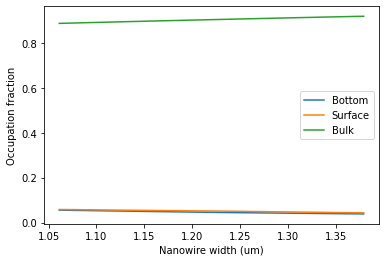

In [260]:
a = occupation_fraction(init_abs,display_width,1)

plt.plot(display_width,a);
plt.xlabel('Nanowire width (um)')
plt.ylabel('Occupation fraction')
plt.legend(['Bottom','Surface','Bulk']);

### Test individual units

Each function provides insight into the behaviour of recombination. These functions provide individual measurements for different widths, and can be run separately. We demonstrate this for the calculation of the bulk carrier lifetime under "top-surface" excitation.

[ 8.13349541  8.10010575  8.06752927  8.0357362   8.00470003  7.97439307
  7.94479039  7.9158678   7.96932095  8.05764362  8.14643836  8.23571076
  8.32545932  8.41569312  8.50641409  8.59762358  8.68932467  8.78152457
  8.8742212   8.96742428  9.06113356  9.15535295  9.25008763  9.34534043
  9.44111606  9.53724497  9.63358143  9.73044712  9.82784575  9.92578368
 10.0242621  10.12328682 10.22286109 10.32299017 10.42367876 10.52493091
 10.62675003 10.72914165 10.83210996 10.93566064 11.03979944 11.14452859
 11.24985248 11.35577775 11.46230893 11.56945136]


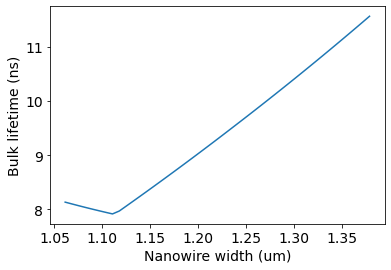

In [487]:
Btop = occupation_fraction(init_abs,display_width,1)
print(t_bulk_model_top(init_abs,display_width,Btop))
plt.plot(display_width,t_bulk_model_top(init_abs,display_width,Btop))
plt.xlabel('Nanowire width (um)')
plt.ylabel('Bulk lifetime (ns)');

We can also calculate what the slope in the lifetime with varying excitation power should be, with the parameters observed.

In [488]:
slopeSA(init_abs,display_width,Btop)

5.671605575693754e-21

As a starting point, we can calculate a range of starting points using the initial parameter vector.

In [489]:
#Print values for models using initial parameters
print(f'Bulk volume = {np.mean(V_bulk(init_abs,display_width)):g} cm^3')
print(f'Top volume = {np.mean(V_SA(init_abs,display_width)):g} cm^3')
print(f'Bottom volume = {np.mean(V_b(init_abs,display_width)):g} cm^3')

Btop = occupation_fraction(init_abs,display_width,1)
Bbot = occupation_fraction(init_abs,display_width,0)
Lds = np.squeeze(init_abs['Ldiff']*np.ones((len(display_width),1)))

print(f'Bulk carrier density = {np.mean(NcarrV(init_abs,display_width,Btop)):g} cm^-3')
print(f'Top carrier density = {np.mean(NcarrSA(init_abs,display_width,Btop)):g} cm^-3')
print(f'Bottom carrier density = {np.mean(NcarrB(init_abs,display_width,Bbot)):g} cm^-3')
print(f'Bulk free trap density = {np.mean(NVeff(init_abs,display_width,Btop)):g} cm^-3')
print(f'Top free trap density = {np.mean(NSAeff(init_abs,display_width,Btop)):g} cm^-3')
print(f'Bulk carrier density bottom = {np.mean(NcarrV_bottom(init_abs,display_width,Bbot)):g} cm^-3')
print(f'Top carrier density bottom = {np.mean(NcarrSA_bottom(init_abs,display_width,Bbot)):g} cm^-3')
print(f'Bottom carrier density bottom = {np.mean(NcarrB_bottom(init_abs,display_width,Bbot)):g} cm^-3')
print(f'Bulk free trap density bottom = {np.mean(NVeff_bottom(init_abs,display_width,Bbot)):g} cm^-3')
print(f'Bulk lifetime = {np.mean(t_bulk_model_top(init_abs,display_width,Btop)):g} ns')
print(f'Top lifetime = {np.mean(t_SA_model_top(init_abs,display_width,Btop)):g} ns')
print(f'Bulk lifetime bottom = {np.mean(t_bulk_model_bottom(init_abs,display_width,Bbot)):g} ns')
print(f'Eg top = {np.mean(E_MC(init_abs,display_width,poly_top)):g} eV')
print(f'Eg bottom = {np.mean(E_MC(init_abs,display_width,poly_bottom)):g} eV')
print(f'IQE top = {np.mean(IQE(init_abs,display_width,Btop)):g}')
print(f'IQE bottom = {np.mean(IQE_bottom(init_abs,display_width,Bbot)):g}')

Bulk volume = 7.13336e-09 cm^3
Top volume = 2.09211e-10 cm^3
Bottom volume = 1.48243e-10 cm^3
Bulk carrier density = 2.7104e+16 cm^-3
Top carrier density = 5.19314e+16 cm^-3
Bottom carrier density = 1.71134e+17 cm^-3
Bulk free trap density = 8.57745e+16 cm^-3
Top free trap density = 3.5787e+16 cm^-3
Bulk carrier density bottom = 3.18193e+16 cm^-3
Top carrier density bottom = 3.64276e+17 cm^-3
Bottom carrier density bottom = 1.71134e+18 cm^-3
Bulk free trap density bottom = 8.34588e+16 cm^-3
Bulk lifetime = 9.41823 ns
Top lifetime = 1.47805 ns
Bulk lifetime bottom = 8.76925 ns
Eg top = 2.34125 eV
Eg bottom = 2.32908 eV
IQE top = 0.00715102
IQE bottom = 0.0557482


## Model fitting

To fit the model to the data, we produce a cost function.

### Cost function

Our cost function is effectively a least-squares minimization. It can fit to one or more of the modules in the dynamical model, with the section made through flags.

In [543]:
#function of normalised residual sum to minimise
def tomin(scaling):
    # Scale the initial parameters
    scaling = np.squeeze(scaling)
    p = {k:v*p for (k,v,p) in zip(init_abs.keys(),init_abs.values(), scaling)}

    
    
    #Look up occupation factors once to speed up
    Btop = occupation_fraction(p,data_width,1)
    Bbot = occupation_fraction(p,data_width,0)     

    #Loop over all modules to calculate cost function
    #modules: [0] - active?
    #         [1] - data and mask
    #         [2] - model
    result = 0;
    for key in modules:
        #only consider module if activated
        if modules[key][0] == True:
        
            #extracts mask for applicable wires
            mask = modules[key][3]
            
            #determine if module is for bottom or top, or the bandgap, and select appropriate occupation_fraction or polynomial
            if key.find('bottom_E_bandgap') == 0:
                extra_argument = poly_bottom
            elif key.find('top_E_bandgap') == 0:
                extra_argument = poly_top
            elif key.find('bottom') == -1:
                extra_argument = Btop[mask,:]
            else:
                extra_argument = Bbot[mask,:]
        
            #extracts data, widths and model results for the module calculate chi squared for the module and add to total chi squared
            data = modules[key][1]
            widths = modules[key][2]
            model_output = modules[key][4](p,widths,extra_argument)

            #Calculates chi squared for module
            module_result = np.sum(np.square(data - model_output) / np.mean(data) )
            
            #adds module chi squared onto total chi squared
            result += module_result
    
    return result

We can create a callback function to monitor the progress of the modelling

In [544]:
def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}'.format(Nfeval, tomin(Xi)))
    Nfeval += 1

### Test fitting function

In [545]:
initial = np.ones((len(init_abs),1))

#Define modules, and choose which to test
#test?,data,widths,mask,models
modules = {'I_ratio' : [True ,Iratios[0],data_width[Iratios[1]],Iratios[1],I_ratio_model_top],
          'top_bulk_lifetime':[True,t_top_bulk_data[0],data_width[t_top_bulk_data[1]],t_top_bulk_data[1],t_bulk_model_top],
              'top_SA_lifetime':[True,t_top_SA_data[0],data_width[t_top_SA_data[1]],t_top_SA_data[1],t_SA_model_top],
              'bottom_lifetime':[True,t_bot_data[0],data_width[t_bot_data[1]],t_bot_data[1],t_bulk_model_bottom],
              't_thresh_SA':[True,thresh_SA[0],data_width[thresh_SA[1]],thresh_SA[1],N_threshSA_av],
              't_thresh_bulk':[True,thresh_bulk[0],data_width[thresh_bulk[1]],thresh_bulk[1],N_threshV_av],
              't_slope_SA':[True,slope_SA[0],data_width[slope_SA[1]],slope_SA[1],slopeSA],
              't_slope_bulk':[True,slope_bulk[0],data_width[slope_bulk[1]],slope_bulk[1],slopeV],
              'top_E_bandgap':[True,Eg_top[0],data_width[Eg_top[1]],Eg_top[1],E_MC],
              'bottom_E_bandgap':[True,Eg_bottom[0],data_width[Eg_bottom[1]],Eg_bottom[1],E_MC]}



#Print target function for initial parameters
start = time.time()
print('Target function value: ',tomin(initial))
end = time.time()

print(f'Time to execute cost function: {end-start:.3}s')

start = time.time()
occupation_fraction(init_abs,data_width,1)
end = time.time()

print(f'Time to execute carrier density calculation: {end-start:.3}s')


Target function value:  20284165962802.984
Time to execute cost function: 0.175s
Time to execute carrier density calculation: 0.0779s


### Run the fit function

We can use scipy optimize with bounded fitting

In [546]:
#bounds
bnds = {'Ldiff' : [0.1, 1.4],
            'krV': [1E-30, 1E-5],
            'ktV': [1E-30, 1E-5],
            'ktSA': [1E-30, 1E-5],
            'NV': [1E12, 1E23] ,
            'NSA': [1E6, 1E20] ,
            'Lrot': [0.1, 10],
            'alpha': [0,70],
            'Eg': [2.33,2.5], 
            'T': [0.009,0.3],
            'alpha2': [0.001,100],
            'Lsurface': [0.0001,0.2],
            'AE': [0,1]}

#normalise bounds
for i in init_abs.keys():
    bnds[i] = tuple(np.array(bnds[i])/init_abs[i])
bnds = list(bnds.values())


Run the fitting, to minimize tomin.

In [547]:
#do the fit
Nfeval = 1
ftol = 1E-6
start = time.time()
res = minimize(tomin,initial,
               options={'maxiter' : 1000, 'disp': True,'ftol': ftol},
               bounds=bnds,
               callback=callbackF)
end = time.time()
print('Time to execute: ', end-start, 's')

   1    15254534452326.937500
   2    1321160803316.248535
   3    973015554029.283203
   4    921886303675.615479
   5    921006963718.244995
   6    921006183709.199463
Time to execute:  33.812150955200195 s
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail in t_slope_bulk from Model (1/1), Data (0/210)
nan
Fail i

In [549]:
#format results vector
results = dict()
i = 0
for key in init_abs.keys():
    results[key] =  init_abs[key] * res.x[i]
    i += 1

#calculate errors using hessian matrix
tmp_i = np.zeros(len(res.x))
uncertainty = np.zeros(len(res.x))
for i in range(len(res.x)):
    tmp_i[i] = 1.0
    hess_inv_i = res.hess_inv(tmp_i)[i]
    uncertainty_i = np.sqrt(max(1, abs(res.fun)) * ftol * hess_inv_i)
    uncertainty[i] = np.sqrt(max(1, abs(res.fun)) * ftol * hess_inv_i)
    tmp_i[i] = 0.0

    
#format errors vector
errors = dict()
i = 0
for key in init_abs.keys():
    errors[key] =  init_abs[key] * uncertainty[i]
    i += 1


print('Initial:')
print(init_abs)
print('Results:')
print(results)
print('Errors:')
print(errors)

Initial:
{'Ldiff': 0.25, 'krV': 7.45e-27, 'ktV': 4.44e-26, 'ktSA': 1.2e-24, 'NV': 8.6e+16, 'NSA': 7.12e+16, 'Lrot': 0.2597, 'alpha': 0.232, 'Eg': 2.371, 'T': 0.064, 'alpha2': 0.363, 'Lsurface': 0.006105, 'AE': 0.9998}
Results:
{'Ldiff': 0.25, 'krV': 7.450000002025959e-27, 'ktV': 4.440000027023714e-26, 'ktSA': 1.2e-24, 'NV': 6.6239985103829496e+16, 'NSA': 1.1193791017578083e+17, 'Lrot': 0.2597, 'alpha': 0.2612753848903894, 'Eg': 2.371, 'T': 0.064, 'alpha2': 0.279808326709353, 'Lsurface': 0.006319300613501843, 'AE': 0.9998}
Errors:
{'Ldiff': 239.9226677115461, 'krV': 7.149695497804078e-24, 'ktV': 4.2610265785570644e-23, 'ktSA': 1.1516288050154212e-21, 'NV': 5.836673229641066e+19, 'NSA': 9.572846430455693e+19, 'Lrot': 249.23166721875407, 'alpha': 185.9190765575765, 'Eg': 2275.426580576303, 'T': 61.4202029341558, 'alpha2': 246.56339354029473, 'Lsurface': 5.631963593801656, 'AE': 959.4987327120152}


## Display results

142740.8131996384


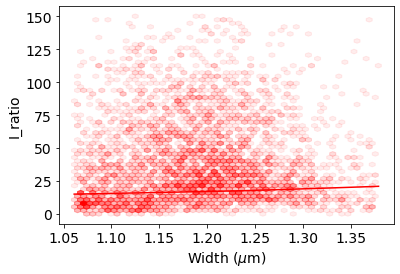

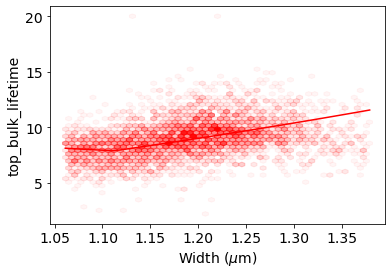

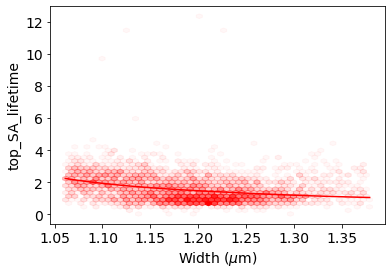

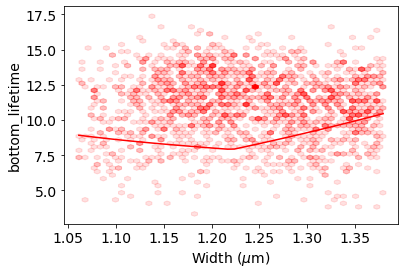

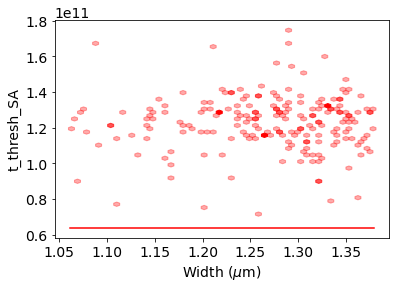

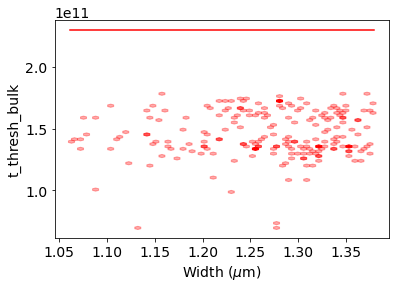

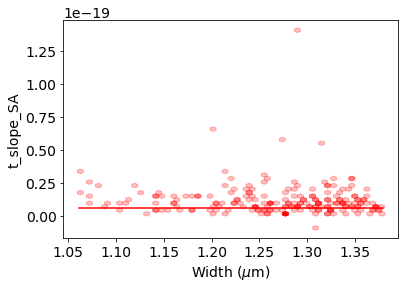

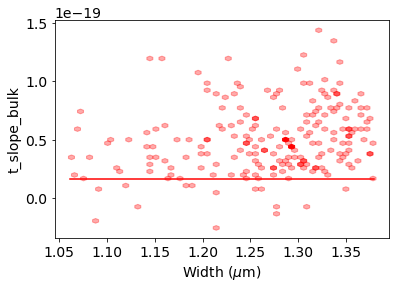

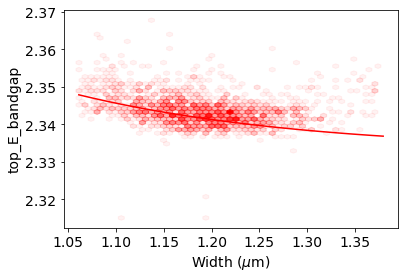

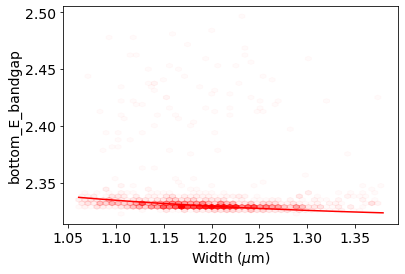

In [511]:
#Optimised results
results = {'Ldiff' : 0.25,
            'krV': 7.45e-27,
            'ktV': 4.44e-26,
            'ktSA': 1.20e-24,
            'NV': 8.60e+16 ,
            'NSA': 7.12e+16 ,
            'Lrot': 0.2597,
            'alpha': 0.232,
            'Eg': 2.371, 
            'T': 0.064,
            'alpha2': 0.363,
            'Lsurface': 0.006105,
            'AE': 0.9998}


#figure settings and colormaps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rc('font', size=14) 
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(1,0,1,c) for c in np.linspace(0,1,100)]
cmappurp = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,1,0,c) for c in np.linspace(0,1,100)]
cmapgreen = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)

Btop = occupation_fraction(results,display_width,1)
Bbot = occupation_fraction(results,display_width,0)


#Loop to plot all output figures
for key in modules.keys():
    #determine if module is for bottom or top, or the bandgap, and select appropriate occupation_fraction or polynomial
    if key.find('bottom_E_bandgap') == 0:
        extra_argument = poly_bottom
    elif key.find('top_E_bandgap') == 0:
        extra_argument = poly_top
    elif key.find('bottom') == -1:
        extra_argument = Btop
    else:
        extra_argument = Bbot

    #extracts data, widths and model results for the module
    data = modules[key][1]
    widths = modules[key][2]
    model_output = modules[key][4](results,display_width,extra_argument)

    #Plot the histogram of data, along with fit result
    plt.figure()
    plt.hexbin(widths,data,gridsize=50,cmap=cmapred)
    if model_output.size == 1:
        model_output = np.multiply(model_output,np.ones(display_width.size))
        
    plt.plot(display_width,model_output,"r-")
    plt.xlabel('Width (${\mu}$m)')
    plt.ylabel(key)